In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/
!unzip /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/StarGAN.zip

/content
Archive:  /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/StarGAN.zip
  inflating: logger.py               
  inflating: main.py                 
  inflating: model.py                
  inflating: solver.py               
  inflating: trai.jpg                
  inflating: data_loader.py          
  inflating: download.sh             
  inflating: gai.jpg                 
  inflating: haarcascade_frontalface_default.xml  


# Train model

## Download dataset

In [ ]:
#run this line 1 time only to downloading the data celebA
!bash download.sh celeba

Streaming output truncated to the last 5000 lines.
  inflating: ./data/celeba/images/195339.jpg  
  inflating: ./data/celeba/images/012465.jpg  
  inflating: ./data/celeba/images/089057.jpg  
  inflating: ./data/celeba/images/147796.jpg  
  inflating: ./data/celeba/images/192463.jpg  
  inflating: ./data/celeba/images/142818.jpg  
  inflating: ./data/celeba/images/148061.jpg  
  inflating: ./data/celeba/images/184432.jpg  
  inflating: ./data/celeba/images/201157.jpg  
  inflating: ./data/celeba/images/097288.jpg  
  inflating: ./data/celeba/images/130371.jpg  
  inflating: ./data/celeba/images/082864.jpg  
  inflating: ./data/celeba/images/017429.jpg  
  inflating: ./data/celeba/images/186077.jpg  
  inflating: ./data/celeba/images/126843.jpg  
  inflating: ./data/celeba/images/200381.jpg  
  inflating: ./data/celeba/images/012555.jpg  
  inflating: ./data/celeba/images/092238.jpg  
  inflating: ./data/celeba/images/008151.jpg  
  inflating: ./data/celeba/images/171418.jpg  
  inflati

## run train

In [ ]:
# Train StarGAN using the CelebA dataset
#num_iters#number of total iterations for training D
#num_iters_decay#number of iterations for decaying 
#n_critic#number of D updates per each G update
#c_dim#attrs number
%cd /content
!python main.py --mode train \
                --dataset CelebA \
                --image_size 256 \
                --celeba_crop_size 178 \
                --batch_size 8 \
                --beta1 0.5 \
                --beta2 0.99 \
                --c_dim 4 \
                --log_step 100 \
                --num_iters 100000 \
                --num_iters_decay 50000 \
                --model_save_step 10000 \
                --sample_step 1000 \
                --lr_update_step 1000 \
                --g_lr 0.0001 \
                --d_lr 0.0001 \
                --n_critic 5 \
                --num_workers 4 \
                --sample_dir /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/samples \
                --log_dir /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5_cpu/logs \
                --model_save_dir /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/models \
                --result_dir /content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/results \
                --selected_attrs Bangs Male No_Beard Straight_Hair

#--num_iters 20000 \
#--num_iters_decay 10000 \
#--model_save_step 5000 \
#--sample_step 1000 \
#--lr_update_step 1000 \
#--g_lr 0.0005 \
#--d_lr 0.0005 \
#--n_critic 5 \
#--selected_attrs Bald Bangs Male No_Beard Straight_Hair

/content
Namespace(attr_path='data/celeba/list_attr_celeba.txt', batch_size=8, beta1=0.5, beta2=0.99, c2_dim=8, c_dim=5, celeba_crop_size=178, celeba_image_dir='data/celeba/images', d_conv_dim=64, d_lr=0.0001, d_repeat_num=6, dataset='CelebA', g_conv_dim=64, g_lr=0.0001, g_repeat_num=6, image_size=256, lambda_cls=1, lambda_gp=10, lambda_rec=10, log_dir='/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5_cpu/logs', log_step=100, lr_update_step=1000, mode='train', model_save_dir='/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/models', model_save_step=10000, n_critic=5, num_iters=100000, num_iters_decay=50000, num_workers=4, rafd_crop_size=256, rafd_image_dir='data/RaFD/train', result_dir='/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/results', resume_iters=None, sample_dir='/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan5d_cpu/samples', sample_step=1000, selected_attrs=['Bald', 'Bangs

In [ ]:
%cd /stargan_celeba/
%ls

[Errno 2] No such file or directory: '/stargan_celeba/'
/content
data_loader.py  drive/   logger.py  model.py      README.md     solver.py
download.sh     LICENSE  main.py    __pycache__/  sample_data/


# use model

In [3]:
import random
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import cv2
%matplotlib inline

from model import Generator
from model import Discriminator

## Config


In [4]:
dataset ='CelebA'
image_size =256
selected_attrs =['Wearing_Lipstick', 'No_Beard', 'Male']
# Dimension of domain labels (1st dataset, i.e. CelebA's selected attrs).
c_dim =3
celeba_image_dir = '/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/results'
model_save_dir ='/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/models'
# Number of conv filters in the first layer of G.
g_conv_dim = 64
# number of residual blocks in G
g_repeat_num = 6
# test model from this step
test_iters = 10000

## Load model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
G = Generator(conv_dim=g_conv_dim, c_dim=c_dim, repeat_num=g_repeat_num)
D = Discriminator(image_size=image_size,conv_dim=g_conv_dim, c_dim=c_dim, repeat_num=g_repeat_num)

In [7]:
def print_network(model, name):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))

In [8]:
print_network(G, 'G')

Generator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [9]:
print_network(D, 'D')

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (conv1): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(2048, 3, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
D
The number of parameters: 44819392


In [10]:
G.to(device)
print('Models moved to', device)
D.to(device)
print('Models moved to', device)

Models moved to cuda
Models moved to cuda


# download pretrained-models

In [ ]:
#%cd /content
#!bash download.sh pretrained-celeba-128x128

In [ ]:
#%cd /content
#!bash download.sh pretrained-celeba-256x256

# load trained model:
## G model & D model

In [37]:
#resume_iters = test_iters
#print('Loading the trained models from step {}...'.format(resume_iters))
#G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
#D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))

G_path = '/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/models/13000-G.ckpt'
D_path = '/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/models/13000-D.ckpt'
#G_path = '/content/stargan_celeba_256/models/200000-G.ckpt'
#D_path = '/content/stargan_celeba_256/models/200000-D.ckpt'
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

## load face_cascade in cv2

In [12]:
CASE_PATH = '/content/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(CASE_PATH)

In [13]:
def crop_face(imgarray, section, margin=20, size=256):
    """
    :param imgarray: full image
    :param section: face detected area (x, y, w, h)
    :param margin: add some margin to the face detected area to include a full head
    :param size: the result image resolution with be (size x size)
    :return: resized image in numpy array with shape (size x size x 3)
    """
    img_h, img_w, _ = imgarray.shape
    if section is None:
        section = [0, 0, img_w, img_h]
    (x, y, w, h) = section
    margin = int(min(w, h) * margin / 100)
    x_a = x - margin
    y_a = y - margin
    x_b = x + w + margin
    y_b = y + h + margin
    if x_a < 0:
        x_b = min(x_b - x_a, img_w - 1)
        x_a = 0
    if y_a < 0:
        y_b = min(y_b - y_a, img_h - 1)
        y_a = 0
    if x_b > img_w:
        x_a = max(x_a - (x_b - img_w), 0)
        x_b = img_w
    if y_b > img_h:
        y_a = max(y_a - (y_b - img_h), 0)
        y_b = img_h
    cropped = imgarray[y_a: y_b, x_a: x_b]
    resized_img = cv2.resize(cropped, (size, size), interpolation=cv2.INTER_AREA)
    resized_img = np.array(resized_img)
    return resized_img

## Generator

In [23]:
from google.colab import files
# seed the pseudorandom number generator
from random import seed
from random import random
#plt.savefig("abc.png")
test_dir = '/content/'
results_dir =  '/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/results'
def tryCvStarGAN(imgFile, setLipMakeUp = False,setNoBeard=False, setMale = False):
    frame = cv2.imread(test_dir+imgFile)
    frame = frame[:, :, ::-1] # CV2'BGR -> RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=10
    )
    if len(faces) is 0:
        print('No face detected, try another image.')
        return
    main_face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
    face_img = crop_face(frame, main_face, margin = 40, size=256)
    image = Image.fromarray(face_img)
    
    # Pre-process the image
    transform = []
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    preprocessed_image = transform(face_img)
    
    # Show the pre-processed source image.
    # Prepare the plot
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow((np.moveaxis(preprocessed_image.numpy(),[0], [2])+1)/2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Pre-process the image
    
    labels = torch.zeros(c_dim)
    # Set the 'LipMakeUp' label.
    if setLipMakeUp is True:
        labels[0] = 1
    # Set the 'Beard' label.
    if setNoBeard is True:
        labels[1] = 1
    # Set the 'Male' label.
    if setMale is True:
        labels[2] = 1
    # Run the generator to generate the desired image with labels.
    print(preprocessed_image.unsqueeze(0).to(device).shape)
    #x_fake = G(x_real, c_trg)
    print(labels)
    generated = G(preprocessed_image.unsqueeze(0).to(device), labels.unsqueeze(0).to(device))
    print(generated.shape)
    #out_src, out_cls = D(x_fake)
    out_src, out_cls = D(preprocessed_image.unsqueeze(0).to(device))
    print(out_cls)
    out_src2, out_cls2 = D(generated)
    print(out_cls2)


    # Show the generated image.
    fig.add_subplot(rows, columns, 2)
    plt.imshow((np.moveaxis(generated.cpu().detach().numpy()[0],[0], [2])+1)/2)
    #save image
    seed(1)
    rand_idx = random()
    plt.savefig(f"{results_dir}/{imgFile}")
    print(f"{results_dir}/{imgFile} saved")
    plt.show()

## to Female

In [15]:
def swapToFemale(imgPath):
    frame = cv2.imread(test_dir+imgPath)
    frame = frame[:, :, ::-1] # CV2'BGR -> RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=10
    )
    if len(faces) is 0:
        print('No face detected, try another image.')
        return
    main_face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
    face_img = crop_face(frame, main_face, margin = 40, size=256)
    image = Image.fromarray(face_img)
    
    # Pre-process the image
    transform = []
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    preprocessed_image = transform(face_img)


    minScore = 1000
    # Three hair color to choose from.
    hairColors = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    for i, color in enumerate(hairColors):
        for stat in range(0,2):
            labels = torch.zeros(c_dim)  #0 0 0 0 0
            labels[i] = 1
            labels[3] = 0
            labels[4] = stat
            generated = G(preprocessed_image.unsqueeze(0).to(device), labels.unsqueeze(0).to(device))
            out_src, out_cls = D(generated)
            maleScore = out_cls[0][3].item()
            if (maleScore<minScore):
                minScore = maleScore
                setHairColor = hairColors[i]
                if (stat==1):
                    setYoung = True
                else:
                    setYoung = False
    print('minScore= ',minScore)
    print('Swapping to female... set: setHairColor=',setHairColor, ' setYoung= ',setYoung)
    tryCvStarGAN(imgPath, setHairColor = setHairColor, setMale = False, setYoung = setYoung)

## to Male

In [ ]:
def swapToMale(imgPath):
    frame = cv2.imread(test_dir+imgPath)
    frame = frame[:, :, ::-1] # CV2'BGR -> RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=10
    )
    if len(faces) is 0:
        print('No face detected, try another image.')
        return
    main_face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
    face_img = crop_face(frame, main_face, margin = 40, size=256)
    image = Image.fromarray(face_img)
    
    # Pre-process the image
    transform = []
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    preprocessed_image = transform(face_img)


    maxScore = -1000
    # Three hair color to choose from.
    hairColors = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']
    for i, color in enumerate(hairColors):
        for stat in range(0,2):
            labels = torch.zeros(c_dim)  #0 0 0 0 0
            labels[i] = 1
            labels[3] = 1
            labels[4] = stat
            generated = G(preprocessed_image.unsqueeze(0).to(device), labels.unsqueeze(0).to(device))
            out_src, out_cls = D(generated)
            maleScore = out_cls[0][3].item()
            if (maleScore>maxScore):
                maxScore = maleScore
                setHairColor = hairColors[i]
                if (stat==1):
                    setYoung = True
                else:
                    setYoung = False
    print('maxScore= ',maxScore)              
    print('Swapping to male... set: setHairColor=',setHairColor, ' setYoung= ',setYoung)
    tryCvStarGAN(imgPath, setHairColor = setHairColor, setMale = True, setYoung = setYoung)

## swap

In [ ]:
def swapGender(imgPath):
    frame = cv2.imread(test_dir+imgPath)
    frame = frame[:, :, ::-1] # CV2'BGR -> RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=10
    )
    if len(faces) is 0:
        print('No face detected, try another image.')
        return
    main_face = max(faces, key=lambda rectangle: (rectangle[2] * rectangle[3]))  # area = w * h
    face_img = crop_face(frame, main_face, margin = 40, size=256)
    image = Image.fromarray(face_img)
    
    # Pre-process the image
    transform = []
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    preprocessed_image = transform(face_img)

    out_src, out_cls = D(preprocessed_image.unsqueeze(0).to(device))
    print(out_cls.shape)
    print(out_cls)
    maleScore = out_cls[0][3].item()
    print(maleScore)
    if (maleScore > 0 ):
        print('Male detected with maleScore= ',maleScore)
        swapToFemale(imgPath)
    else:
        print('Female detected with maleScore= ',maleScore)
        swapToMale(imgPath)

# time to see some results

torch.Size([1, 5])
tensor([[  0.5316, -12.2689,  -6.4685,   2.2483,   0.2115]], device='cuda:0',
       grad_fn=<ViewBackward>)
2.248302698135376
Male detected with maleScore=  2.248302698135376
minScore=  -1.3842655420303345
Swapping to female... set: setHairColor= Brown_Hair  setYoung=  False
torch.Size([1, 3, 256, 256])
tensor([0., 0., 1., 0., 0.])
torch.Size([1, 3, 256, 256])
tensor([[  0.5316, -12.2689,  -6.4685,   2.2483,   0.2115]], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([[-1.5238e+00, -8.8085e+00, -4.4751e+00, -1.3843e+00, -2.3136e-03]],
       device='cuda:0', grad_fn=<ViewBackward>)
/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan_celeba/results/trai.jpg saved


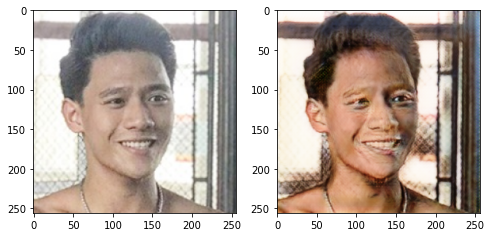

In [ ]:
swapGender("trai.jpg")

label: lip/beard/male
torch.Size([1, 3, 256, 256])
tensor([1., 1., 0.])
torch.Size([1, 3, 256, 256])
tensor([[-3.5590,  1.9335,  2.7924]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[-7.1883,  1.5717,  7.2478]], device='cuda:0', grad_fn=<ViewBackward>)
/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/results/trai.jpg saved


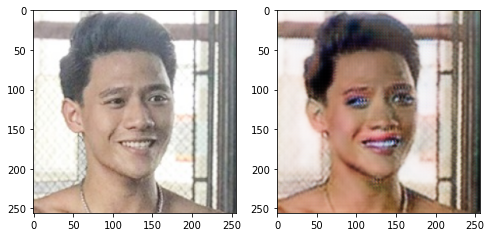

In [41]:
print("label: lip/beard/male")
tryCvStarGAN('trai.jpg', setLipMakeUp = True, setNoBeard=True, setMale = False)

label: lip/beard/male
torch.Size([1, 3, 256, 256])
tensor([0., 0., 0.])
torch.Size([1, 3, 256, 256])
tensor([[-3.3633,  1.2707,  3.9535]], device='cuda:0', grad_fn=<ViewBackward>)
tensor([[-2.2415,  0.7779,  2.7632]], device='cuda:0', grad_fn=<ViewBackward>)
/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/3d_256_178_16/results/gai.jpg saved


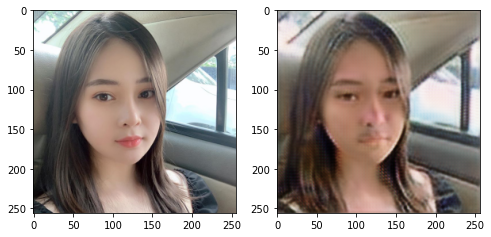

In [40]:
print("label: lip/beard/male")
tryCvStarGAN('gai.jpg', setLipMakeUp = False, setNoBeard=False, setMale = False)

torch.Size([1, 5])
tensor([[-5.3969, -7.0018,  0.2816, -0.0779, -0.5264]], device='cuda:0',
       grad_fn=<ViewBackward>)
-0.0778726264834404
Female detected with maleScore=  -0.0778726264834404
maxScore=  1.6926735639572144
Swapping to male... set: setHairColor= Blond_Hair  setYoung=  False
torch.Size([1, 3, 256, 256])
tensor([0., 1., 0., 1., 0.])
torch.Size([1, 3, 256, 256])
tensor([[-5.3969, -7.0018,  0.2816, -0.0779, -0.5264]], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([[-14.1863,  -2.6415,  -2.8456,   1.6927,  -1.4363]], device='cuda:0',
       grad_fn=<ViewBackward>)
/content/drive/MyDrive/Nhom05_DeepLearning_GenderSwap/Project3/stargan_celeba/results/gai.jpg saved


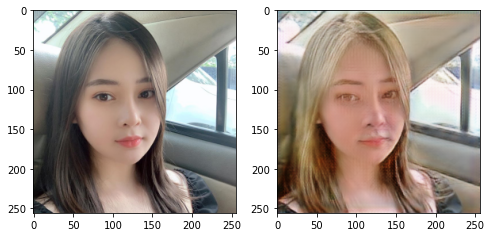

In [ ]:
swapGender("gai.jpg")